#  Fit linear regression model

Step 1: Load packages

In [115]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns; sns.set()
import scipy
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from scipy import stats
from scipy.stats import zscore
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
from mpl_toolkits.axes_grid1 import make_axes_locatable
sns.set_style("white")
sns.set_style("ticks")

Step 2: Init paths

In [116]:
path_store_figure = './figures/'

Step 3: Load pooled subject CSV cintaining RTs, feature distaces, etc, and do linear modeling

In [117]:
# init feat names
feats_column_name = ['pitch','mfcc', 'mel','scentroid','harm','intensity','xvec']
# load CSV
url = './dataAnalysis/data/csvs/praat_pooled_subject_response_acoustic_feats_data_euc.csv'
DF = pd.read_csv(url)
# make RT column
DF['RT'] = DF['t_resp'] - DF['t_end'] # make a response time column
# make incorrect column
DF['incorrect'] = np.abs(DF['label'] - DF['response']) # make a correct response column
# collect indices  of outliers
indx = []
indx.append(DF.loc[DF['session'] == 'TRAIN'].index.to_numpy()) # pick train samples
indx.append(np.where(DF["response"].values <0)[0]) # pick erroneous capture
indx.append(np.where(DF["RT"].values <.02)[0]) # pick RT<20 msec
indx.append(np.where(DF["RT"].values >2)[0]) # pick RT>2000 msec

In [118]:
# pool indices to drop
indx_drop  = list(set(indx[0]) | set(indx[1]) | set(indx[2]) | set(indx[3]))
DF_pruned = DF.copy()
DF_pruned = DF_pruned.drop(index=indx_drop,axis=0)
DF_pruned = DF_pruned.dropna(axis=0)
# save pruned CSV
DF.to_csv('./dataAnalysis/data/csvs/praat_pooled_subject_response_acoustic_feats_data_pruned.csv',index=False) 

In [119]:
# Fit RT by drawing subsets from the DF_pruned
lang_type = [0,1] # chin/eng
label_type = [1,2] # 1 talker/2 talker
incorrect_type = [0,1] # correct/incorrect

pooled_pvals_thres = []
pooled_rsquare = []
for i in range(len(lang_type)):
    pooled_pvals_thres.append([])
    pooled_rsquare.append([])
    
    for j in range(len(incorrect_type)):
        pooled_pvals_thres[i].append([])
        pooled_rsquare[i].append([])
        
        for k in range(len(label_type)):
            pooled_pvals_thres[i][j].append([])
            pooled_rsquare[i][j].append([])
        
            DF_pruned = DF.copy()
            DF_pruned = DF_pruned.drop(index=indx_drop,axis=0)
            DF_pruned = DF_pruned.dropna(axis=0)
            DF_pruned = DF_pruned.loc[(DF_pruned['lang']==lang_type[i])\
                                     &(DF_pruned['incorrect']==incorrect_type[j])\
                                     &(DF_pruned['label']==label_type[k])]
            DF_pruned[feats_column_name] = DF_pruned[feats_column_name].apply(zscore)
            
            # fit model
            md_1 = smf.ols("np.log(RT) ~ mel+mfcc+intensity+scentroid+harm+pitch+xvec\
                   +t_end+C(subID)", data=DF_pruned).fit()
            
            r_square_pooled  = md_1.rsquared
            p_vals_pooled = md_1.pvalues.to_frame().loc[:,0].values
            coeffs_pooled = md_1.params.to_frame().loc[:,0].values
            labels = md_1.pvalues.to_frame().index.values
            indx = [0]+list(np.arange(28,len(labels)))

            table = sm.stats.anova_lm(md_1, typ=2) # Type 2 ANOVA DataFrame
            p_vals_pooled = np.array(table['PR(>F)'].values[:-1])
            p_vals_pooled_thres = p_vals_pooled < 0.05
            p_vals_pooled_thres = p_vals_pooled_thres.astype(int)
            sub_indx = np.where(p_vals_pooled_thres==1)[0]
            coeffs_pooled_subset = coeffs_pooled[indx]
            
            pooled_pvals_thres[i][j][k].append(p_vals_pooled_thres)
            pooled_rsquare[i][j][k].append(r_square_pooled)
            
p_labels = ['SUB_ID','MEL','MFCC','INTENSITY','SCENTROID',\
                   'HNR','PITCH','XVEC','$T_d$']
            

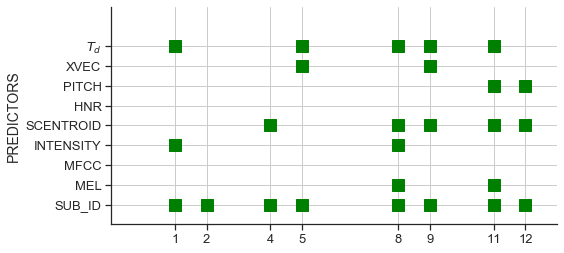

In [120]:
# make plots
fig, ax = plt.subplots(figsize=(8,4))
cnt = 0
for i in range(len(lang_type)):
    for j in range(len(incorrect_type)):
        for k in range(len(label_type)):
            p_vals_pooled_thres = pooled_pvals_thres[i][j][k][0]
            sub_indx = np.where(p_vals_pooled_thres==1)[0]
            plt.plot(cnt+np.ones((len(sub_indx),1)),sub_indx,'s',color='green',markersize=12)
            cnt = cnt+1
        cnt = cnt+1
    cnt = cnt+1
plt.grid(True)
# ax.set_xlabel('SUBJECT ID',fontsize=14)
ax.set_ylabel('PREDICTORS',fontsize=14)
ax.set_yticks(np.arange(0,len(p_labels),1))
ax.set_yticklabels(p_labels, rotation=0)
ax.set_xticks([1,2,4,5,8,9,11,12])
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.set_xlim([-1,13])
ax.set_ylim([-1,10])
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.savefig(path_store_figure+"human_pvals.pdf", dpi=None, facecolor='w', edgecolor='w',
             orientation='portrait', papertype=None, format='pdf',transparent=False, bbox_inches='tight', pad_inches=None, metadata=None)
plt.show()


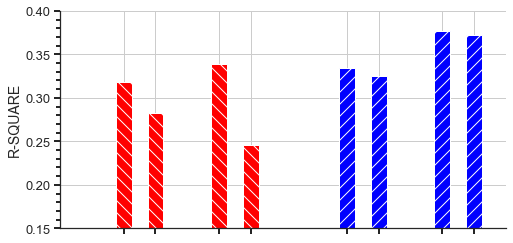

In [121]:
fig, ax = plt.subplots(figsize=(8,4))
cnt = 0
for i in range(len(lang_type)):
    for j in range(len(label_type)):
        for k in range(len(incorrect_type)):
            if i == 0:
                ax.bar(1+cnt,pooled_rsquare[i][j][k],align='center',alpha=1,hatch="\\\\", width=.5,capsize=2,color='red')
            else:
                ax.bar(1+cnt,pooled_rsquare[i][j][k],align='center',alpha=1,hatch="//", width=.5,capsize=2,color='blue')
            cnt = cnt+1
        cnt = cnt+1
    cnt = cnt+1
plt.grid(True)
# ax.set_xlabel('SUBJECT ID',fontsize=14)
ax.set_ylabel('R-SQUARE',fontsize=14)
ax.set_ylim([.15,.4])
ax.set_xlim([-1,13])
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.tick_params(which='both', width=2)
ax.set_xticks([1,2,4,5,8,9,11,12])
ax.set_xticklabels([''])
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.savefig(path_store_figure+"human_rsquare.pdf", dpi=None, facecolor='w', edgecolor='w',
             orientation='portrait', papertype=None, format='pdf',transparent=False, bbox_inches='tight', pad_inches=None, metadata=None)
plt.show()

